<a href="https://colab.research.google.com/github/emmelinetsen/faceAI/blob/master/TFX_for_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Serve Model using TensorFlow Serving

Reference: https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update


deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  11319      0 --:--:-- --:--:-- --:--:-- 11319
OK
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:2 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://ppa.laun

In [55]:
!apt-get install tensorflow-model-server


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.1.0).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [0]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [57]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment
TensorFlow version: 2.2.0


##TFX Serving with first model

In [0]:
from tensorflow.keras.models import load_model
# loading CNN model for facial expression recognition
model = load_model('/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/CNN_Model.h5') 

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 64)        1792      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)       

In [0]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 304
drwxr-xr-x 2 root root   4096 May 16 22:58 assets
-rw-r--r-- 1 root root 302053 May 16 22:58 saved_model.pb
drwxr-xr-x 2 root root   4096 May 16 22:58 variables


In [0]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_10_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 48, 48, 3)
        name: serving_default_conv2d_10_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_4'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 8)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0516 22:58:55.186244 140008955139968 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_cor

In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [0]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=cnn_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [0]:
!tail server.log

2020-05-16 22:59:01.151296: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-05-16 22:59:01.169707: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:203] Restoring SavedModel bundle.
2020-05-16 22:59:01.214710: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:152] Running initialization op on SavedModel bundle at path: /tmp/1
2020-05-16 22:59:01.225350: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:333] SavedModel load for tags { serve }; Status: success: OK. Took 77725 microseconds.
2020-05-16 22:59:01.226805: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-05-16 22:59:01.226918: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cnn_model version: 1}
2020-05-16 22:59:01.

'{"signature_name": "serving_default", "instances": [[[[167, 154, 146], [167, 155, 147], [167, 155, 145], [168, 158, 149], [168, 156, 149], [169, 157, 148], [168, 157, 150], [168, 157, 150], [170, 157, 150], [170, 159, 152], [170, 157, 148], [171, 156, 148], [177, 162, 151], [152, 136, 127], [156, 142, 138], [111, 98, 94], [113, 103, 101], [39, 31, 31], [115, 102, 95], [92, 85, 85], [57, 52, 60], [48, 40, 38], [53, 41, 38], [48, 39, 37], [60, 50, 48], [27, 21, 17], [39, 29, 27], [48, 37, 37], [88, 76, 74], [72, 59, 56], [32, 24, 23], [75, 64, 61], [117, 106, 101], [151, 138, 130], [182, 174, 165], [175, 163, 152], [172, 161, 152], [170, 159, 150], [169, 158, 150], [169, 158, 150], [168, 156, 148], [169, 157, 149], [167, 156, 148], [167, 155, 147], [166, 155, 147], [166, 155, 147], [166, 154, 145], [165, 153, 143]], [[169, 156, 148], [167, 156, 149], [169, 158, 150], [169, 159, 152], [169, 159, 152], [170, 159, 151], [170, 158, 151], [172, 159, 150], [168, 158, 152], [171, 159, 151], [1

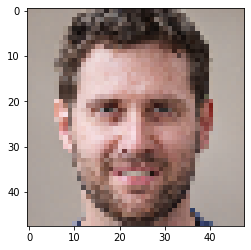

In [0]:
from keras.preprocessing import image
import json

# using images created from GAN for testing the model serving on TFX
img1 = image.load_img("/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/stylegan2/image2.png",target_size=(48,48))
img1 = np.asarray(img1)
plt.imshow(img1)
img1 = np.expand_dims(img1, axis=0)

data = json.dumps({"signature_name": "serving_default", "instances": img1.tolist()})
data

In [0]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/cnn_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
output = predictions[0]

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


'fear'

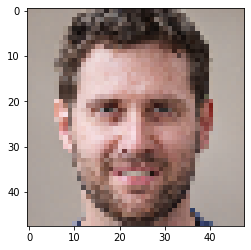

In [0]:
from keras.preprocessing import image

classes = ['angry','disgust','fear','happy','sad','surprise','neutral','embarrassed']

img = image.load_img("/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/stylegan2/image2.png",target_size=(48,48))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

print(output)
classes[np.argmax(output)]

## TFX Serving with second model after tuning

In [0]:
import pandas as pd

def load_data_csv(data_dir):
  data_test = pd.read_csv(data_dir+'data_test_new22.csv')
  data_test.array=data_test.array.apply(arrs_str_to_arrs)  
  return data_test

def arrs_str_to_arrs(array_str):  
  img_arr = np.array([int(x) for x in array_str.split()])
  img_arr = img_arr.reshape(48,48,3)
  return img_arr 

test = load_data_csv('/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/')


In [58]:
from tensorflow.keras.models import load_model
# loading CNN model for facial expression recognition
model = load_model('/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/CNN_Model_2.h5') 
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 48, 48, 64)        1792      
_________________________________________________________________
batch_normalization_28 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_29 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_30 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 24, 24, 64)       

In [100]:
test

,emotion,array
0,0,"[[[170, 170, 170], [118, 118, 118], [101, 101,..."
1,5,"[[[7, 7, 7], [5, 5, 5], [8, 8, 8], [6, 6, 6], ..."
2,6,"[[[232, 232, 232], [240, 240, 240], [241, 241,..."
3,4,"[[[200, 200, 200], [197, 197, 197], [149, 149,..."
4,2,"[[[40, 40, 40], [28, 28, 28], [33, 33, 33], [5..."
...,...,...
3638,7,"[[[254, 254, 254], [254, 254, 254], [254, 254,..."
3639,7,"[[[159, 159, 159], [158, 158, 158], [158, 158,..."
3640,7,"[[[249, 249, 249], [249, 249, 249], [249, 249,..."
3641,7,"[[[142, 142, 142], [143, 143, 143], [157, 157,..."


In [0]:
from keras.utils.np_utils import to_categorical

test_X = np.array(test.array.tolist()).reshape(-1,48,48,3)/255.0 
test_y = to_categorical(test.emotion, 8)

In [104]:
res = model.evaluate(test_X, test_y)
res

114/114 [==============================] - 1s 8ms/step - loss: 0.9599 - accuracy: 0.6453


[0.9598801136016846, 0.6453472375869751]

In [123]:
predictions = model.predict(test_X)
predictions[0].shape

(8,)

In [124]:
predictions[0]

array([3.6173365e-01, 9.5779002e-03, 1.4115493e-01, 1.0315957e-03,
       2.2540869e-01, 8.4689520e-03, 2.5262427e-01, 2.1554598e-11],
      dtype=float32)

In [125]:
np.argmax(predictions[0])

0

In [59]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 832
drwxr-xr-x 2 root root   4096 May 16 22:58 assets
-rw-r--r-- 1 root root 840796 May 16 23:36 saved_model.pb
drwxr-xr-x 2 root root   4096 May 16 23:36 variables


In [60]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_73_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 48, 48, 3)
        name: serving_default_conv2d_73_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_18'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 8)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0516 23:36:43.440668 140533401761664 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_co

In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [62]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8502 \
  --model_name=cnn_model_2 \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [63]:
!tail server.log

2020-05-16 23:36:45.600866: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-05-16 23:36:45.634166: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:203] Restoring SavedModel bundle.
2020-05-16 23:36:45.727745: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:152] Running initialization op on SavedModel bundle at path: /tmp/1
2020-05-16 23:36:45.759226: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:333] SavedModel load for tags { serve }; Status: success: OK. Took 167943 microseconds.
2020-05-16 23:36:45.763395: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-05-16 23:36:45.763551: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cnn_model_2 version: 1}
2020-05-16 23:36:

### Using Test Image for testing the model serving on TFX


'{"signature_name": "serving_default", "instances": [[[[0.6666666666666666, 0.6666666666666666, 0.6666666666666666], [0.4627450980392157, 0.4627450980392157, 0.4627450980392157], [0.396078431372549, 0.396078431372549, 0.396078431372549], [0.34509803921568627, 0.34509803921568627, 0.34509803921568627], [0.34509803921568627, 0.34509803921568627, 0.34509803921568627], [0.29411764705882354, 0.29411764705882354, 0.29411764705882354], [0.3058823529411765, 0.3058823529411765, 0.3058823529411765], [0.3215686274509804, 0.3215686274509804, 0.3215686274509804], [0.25882352941176473, 0.25882352941176473, 0.25882352941176473], [0.2901960784313726, 0.2901960784313726, 0.2901960784313726], [0.26666666666666666, 0.26666666666666666, 0.26666666666666666], [0.23137254901960785, 0.23137254901960785, 0.23137254901960785], [0.24705882352941178, 0.24705882352941178, 0.24705882352941178], [0.25098039215686274, 0.25098039215686274, 0.25098039215686274], [0.2549019607843137, 0.2549019607843137, 0.2549019607843

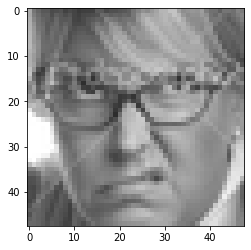

In [138]:
from keras.preprocessing import image
import json

# using images created from GAN for testing the model serving on TFX
# img1 = image.load_img("/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/stylegan2/image0.png",target_size=(48,48))
# img1 = np.asarray(img1)
img1 = test.array[0]/255
plt.imshow(img1)
img1 = np.expand_dims(img1, axis=0)

data = json.dumps({"signature_name": "serving_default", "instances": img1.tolist()})
data

[0.361733884, 0.00957792811, 0.14115493, 0.0010315954, 0.225408599, 0.00846895948, 0.252624035, 2.15546522e-11]


'angry'

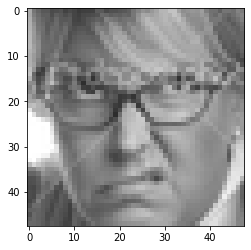

In [139]:
from keras.preprocessing import image
import requests

headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8502/v1/models/cnn_model_2:predict', data=data, headers=headers)
pred = json.loads(json_response.text)['predictions']
output = pred[0]


classes = ['angry','disgust','fear','happy','sad','surprise','neutral','embarrassed']

# img = image.load_img("/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/stylegan2/image0.png",target_size=(48,48))
img = test.array[0]
plt.imshow(img)
img = np.expand_dims(img, axis=0)

print(output)
classes[np.argmax(output)]

### Using Image Created from GAN for testing the model serving on TFX

'{"signature_name": "serving_default", "instances": [[[[0.44313725490196076, 0.37254901960784315, 0.2980392156862745], [0.43529411764705883, 0.3686274509803922, 0.2901960784313726], [0.43137254901960786, 0.3607843137254902, 0.2901960784313726], [0.44313725490196076, 0.37254901960784315, 0.2901960784313726], [0.4549019607843137, 0.3843137254901961, 0.3058823529411765], [0.4588235294117647, 0.39215686274509803, 0.3176470588235294], [0.4823529411764706, 0.40784313725490196, 0.3215686274509804], [0.48627450980392156, 0.4117647058823529, 0.3333333333333333], [0.48627450980392156, 0.4196078431372549, 0.3411764705882353], [0.49411764705882355, 0.42745098039215684, 0.34509803921568627], [0.47843137254901963, 0.4117647058823529, 0.3333333333333333], [0.4980392156862745, 0.43137254901960786, 0.3607843137254902], [0.5058823529411764, 0.43529411764705883, 0.35294117647058826], [0.5058823529411764, 0.43529411764705883, 0.35294117647058826], [0.4980392156862745, 0.43137254901960786, 0.35686274509803

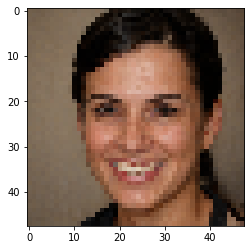

In [140]:
from keras.preprocessing import image
import json

saimg1 = image.load_img("/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/stylegan2/image0.png",target_size=(48,48))
img1 = np.asarray(img1)/255
plt.imshow(img1)
img1 = np.expand_dims(img1, axis=0)

data = json.dumps({"signature_name": "serving_default", "instances": img1.tolist()})
data

In [0]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8502/v1/models/cnn_model_2:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
output = predictions[0]

[6.12283611e-06, 2.26132148e-20, 1.05902842e-07, 0.999824107, 6.13563429e-07, 6.18885068e-08, 0.000168941624, 1.94697734e-23]


'happy'

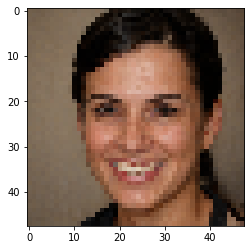

In [142]:
from keras.preprocessing import image

classes = ['angry','disgust','fear','happy','sad','surprise','neutral','embarrassed']

img = image.load_img("/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/stylegan2/image0.png",target_size=(48,48))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

print(output)
classes[np.argmax(output)]

'{"signature_name": "serving_default", "instances": [[[[0.30980392156862746, 0.23921568627450981, 0.16470588235294117], [0.29411764705882354, 0.2235294117647059, 0.1568627450980392], [0.30196078431372547, 0.23529411764705882, 0.17254901960784313], [0.3137254901960784, 0.24313725490196078, 0.16470588235294117], [0.28627450980392155, 0.2235294117647059, 0.1568627450980392], [0.2901960784313726, 0.22745098039215686, 0.14901960784313725], [0.26666666666666666, 0.21176470588235294, 0.1568627450980392], [0.25882352941176473, 0.21176470588235294, 0.16470588235294117], [0.25882352941176473, 0.21568627450980393, 0.17254901960784313], [0.4745098039215686, 0.403921568627451, 0.35294117647058826], [0.5764705882352941, 0.49411764705882355, 0.4470588235294118], [0.49019607843137253, 0.4196078431372549, 0.37254901960784315], [0.5411764705882353, 0.4627450980392157, 0.43137254901960786], [0.41568627450980394, 0.3568627450980392, 0.3137254901960784], [0.6039215686274509, 0.5333333333333333, 0.486274509

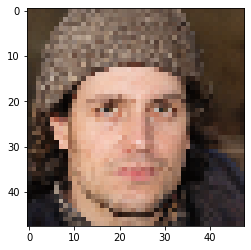

In [157]:
from keras.preprocessing import image
import json

img1 = image.load_img("/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/stylegan2/image900.png",target_size=(48,48))
img1 = np.asarray(img1)/255
plt.imshow(img1)
img1 = np.expand_dims(img1, axis=0)

data = json.dumps({"signature_name": "serving_default", "instances": img1.tolist()})
data

In [0]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8502/v1/models/cnn_model_2:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
output = predictions[0]

[0.0458349213, 3.94001631e-09, 0.012209137, 0.00210829754, 0.109127142, 2.6029853e-05, 0.830694497, 1.98055497e-14]


'neutral'

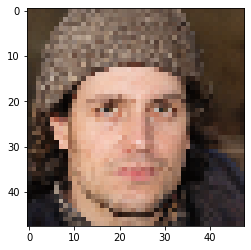

In [160]:
from keras.preprocessing import image

classes = ['angry','disgust','fear','happy','sad','surprise','neutral','embarrassed']

img = image.load_img("/content/drive/My Drive/CMPE 258 - Deep Learning/258_final_project/data/stylegan2/image900.png",target_size=(48,48))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

print(output)
classes[np.argmax(output)]